In [11]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

from datasets.coco.create_annotation_coco import get_new_shape

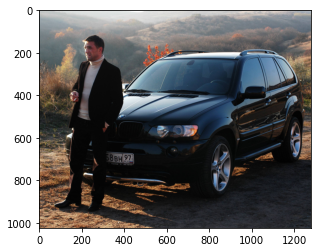

In [12]:
# Photo from a Russian movie "Bumer 2"
img_fp = 'C:/Users/Art/PycharmProjects/Course1/resources/imgs/BMW-E53.jpg'
img = plt.imread(img_fp)
plt.figure()
plt.imshow(img)
plt.show()

icons_dir_fp = 'C:/Users/Art/PycharmProjects/Course1/resources/icons'
icons_sps = os.listdir(icons_dir_fp)
icons = []
icons_sizes = []
for sp in sorted(icons_sps):
    fp = os.path.join(icons_dir_fp, sp)
    icon = cv2.imread(fp)
    # Turned out icons had an Alpha channel
    icon = cv2.cvtColor(icon, cv2.COLOR_BGRA2RGB)
    icons_sizes.append(icon.shape[0])
    icons.append(icon[..., :3])

order = np.argsort(icons_sizes)

h_new, w_new = get_new_shape(img.shape[0], img.shape[1])
img = cv2.resize(img, (w_new, h_new), interpolation=cv2.INTER_LANCZOS4)

### Put icons on the large image and choose a size of minimum anchors valuable

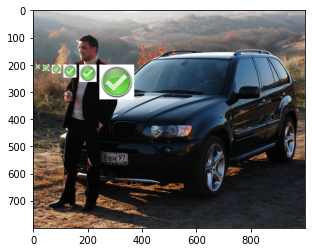

True

In [13]:
x = 10
y = 200
for i in order:
    icon = icons[i]
    h, w = icon.shape[:2]
    img[y:y + h, x:x + w] = icon
    img = cv2.putText(img, f'{h}', org=(x, y), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=0.5, color=(255, 0, 3), thickness=1)
    x = x + w + 10

plt.imshow(img)
plt.show()

t = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite(img_fp[:-3] + 'WithIcons.' + img_fp[-3:], t)
# The smallest size which seems valuable to recognize is 32

In [14]:
from pycocotools.coco import COCO
ann_dir_fp = 'D:/Datasets/COCO/annotations'
subset = 'train'
color = 'g' if subset=='val' else 'r'
ann_fp = os.path.join(ann_dir_fp, f'instances_{subset}2017.json')
coco = COCO(annotation_file=ann_fp)

loading annotations into memory...
Done (t=34.52s)
creating index...
index created!


### Check stats for annotations

In [15]:
def stats(coco_subset, subset, color, mode='Imgs', with_rescale=True, min_size=24):
    assert mode in ('Imgs', 'Anns')
    imgs_only = mode == 'Imgs'

    dir_fp = 'C:/Users/Art/PycharmProjects/Course1/resources/coco_hwdistr'
    heights = []
    widths = []
    for img_id in coco.imgs:
        img_h = coco.imgs[img_id]['height']
        img_w = coco.imgs[img_id]['width']

        if with_rescale:
            img_h_new, img_w_new = get_new_shape(img_h, img_w)
            h_ratio = img_h / img_h_new
            w_ratio = img_w / img_w_new
            img_h, img_w = img_h_new, img_w_new

        if imgs_only:
            heights.append(img_h)
            widths.append(img_w)
            continue

        ann_ids = coco_subset.getAnnIds(imgIds=[img_id])
        anns = coco_subset.loadAnns(ann_ids)
        for ann in anns:
            _, _, h, w = ann['bbox']
            if with_rescale:
                h = int(h / h_ratio)
                w = int(w / w_ratio)
            heights.append(h)
            widths.append(w)

    heights = np.array(heights)
    widths = np.array(widths)
    heights_min, heights_max = heights.min(), heights.max()
    widths_min, widths_max = widths.min(), widths.max()

    total_smaller = np.array((heights < min_size) |
                             (widths < min_size)).sum()
    total_bigger = len(heights) - total_smaller
    print('Stats for images')
    print('Subset', subset, 'minimum size', min_size)
    print('Height min/max:', heights_min, heights_max)
    print('Width min/max: ', widths_min, widths_max)
    print('Total annotations:', len(heights))
    print(f'Bigger than {min_size}: ', total_bigger)
    print(f'Smaller than {min_size}:', total_smaller)

    plt.figure(figsize=(15, 15))
    title = f'{mode} heights/widths distribution for subset {subset} WithRescale {with_rescale}'
    plt.title(title)
    plt.scatter(y=heights, x=widths, color=color, marker='.')
    plt.xlim(-5, widths_max + 10)
    plt.ylim(-5, heights_max + 10)
    plt.xlabel('Widths')
    plt.ylabel('Heights')
    plt.xticks(np.arange(0, widths_max + 50, 50))
    plt.yticks(np.arange(0, heights_max + 50, 50))
    plt.grid(True)
    sp = f'{mode}HWDistribution-COCO-{subset}2017 WithRescale{with_rescale}.png'
    fp = os.path.join(dir_fp, sp)
    plt.savefig(fp)
    plt.show()


### Check stats for annotations

Stats for images
Subset train minimum size 24
Height min/max: 0.23 640.0
Width min/max:  0.0 640.0
Total annotations: 860001
Bigger than 24:  581307
Smaller than 24: 278694


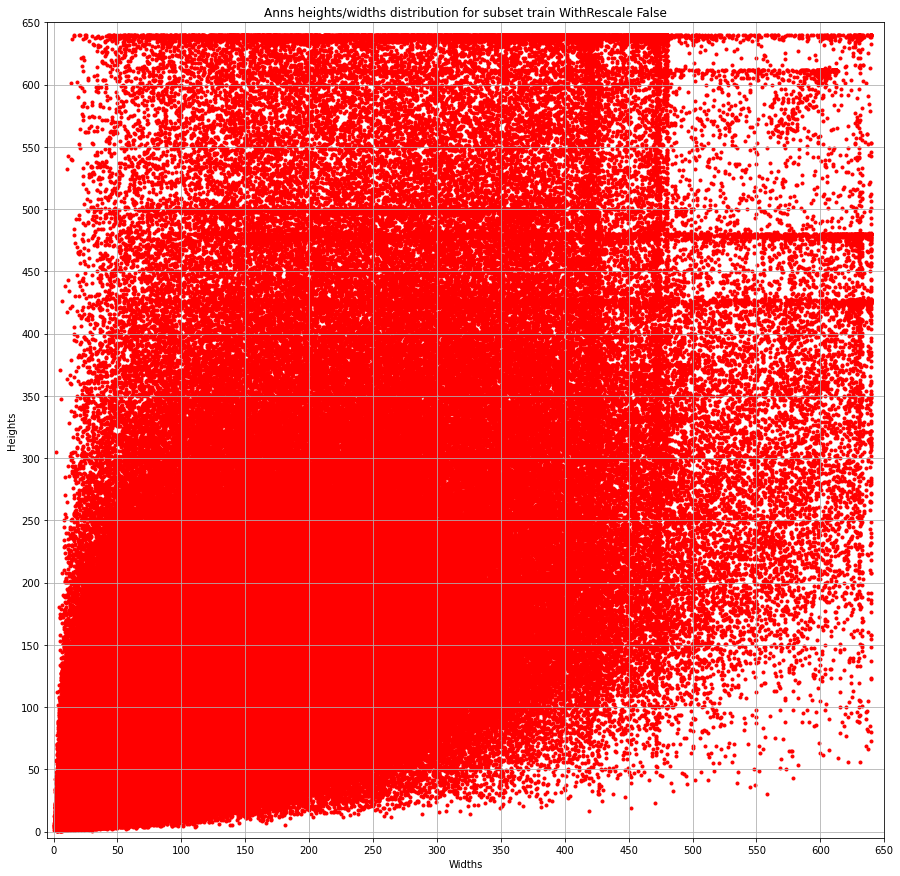

In [16]:
stats(coco, subset, color, mode='Anns', with_rescale=False, min_size=24)

Stats for images
Subset train minimum size 16
Height min/max: 0 1333
Width min/max:  0 1331
Total annotations: 860001
Bigger than 16:  788458
Smaller than 16: 71543


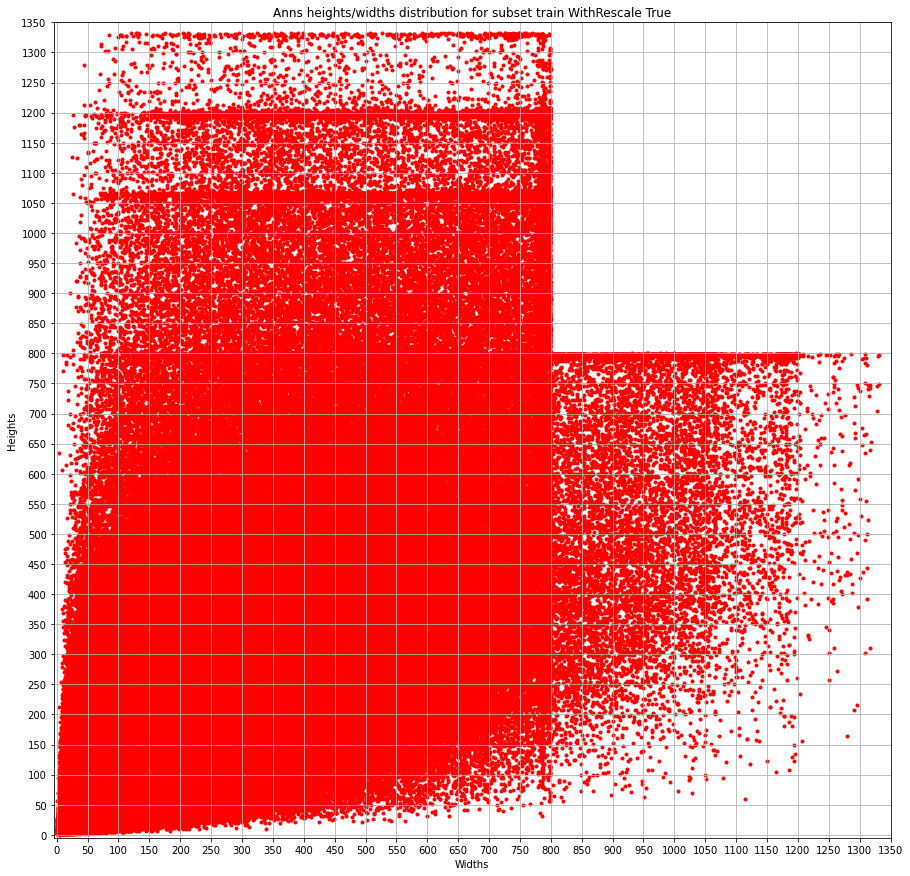

In [17]:
# With min_size=24: bigger 721292, smaller 138709
# With min_size=16: bigger 788458, smaller  71543
stats(coco, subset, color, mode='Anns', with_rescale=True, min_size=16)

### Check stats for images

Stats for images
Subset train minimum size 32
Height min/max: 51 640
Width min/max:  59 640
Total annotations: 118287
Bigger than 32:  118287
Smaller than 32: 0


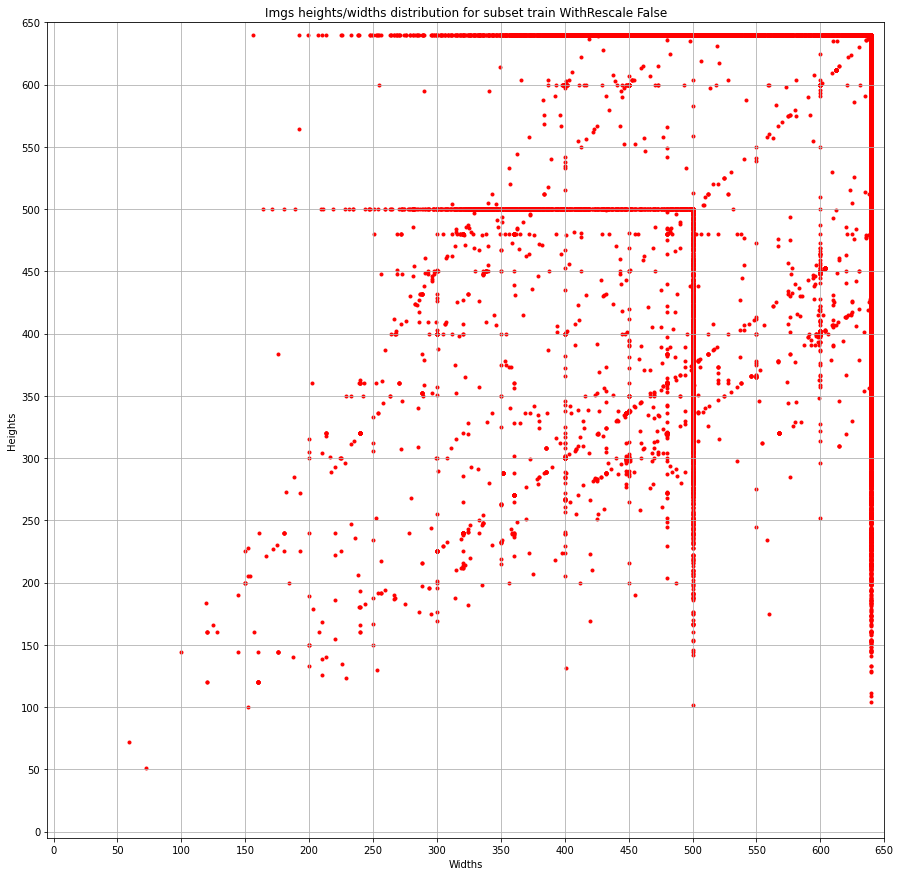

In [18]:
stats(coco, subset, color, mode='Imgs', with_rescale=False, min_size=32)

Stats for images
Subset train minimum size 32
Height min/max: 216 1333
Width min/max:  324 1333
Total annotations: 118287
Bigger than 32:  118287
Smaller than 32: 0


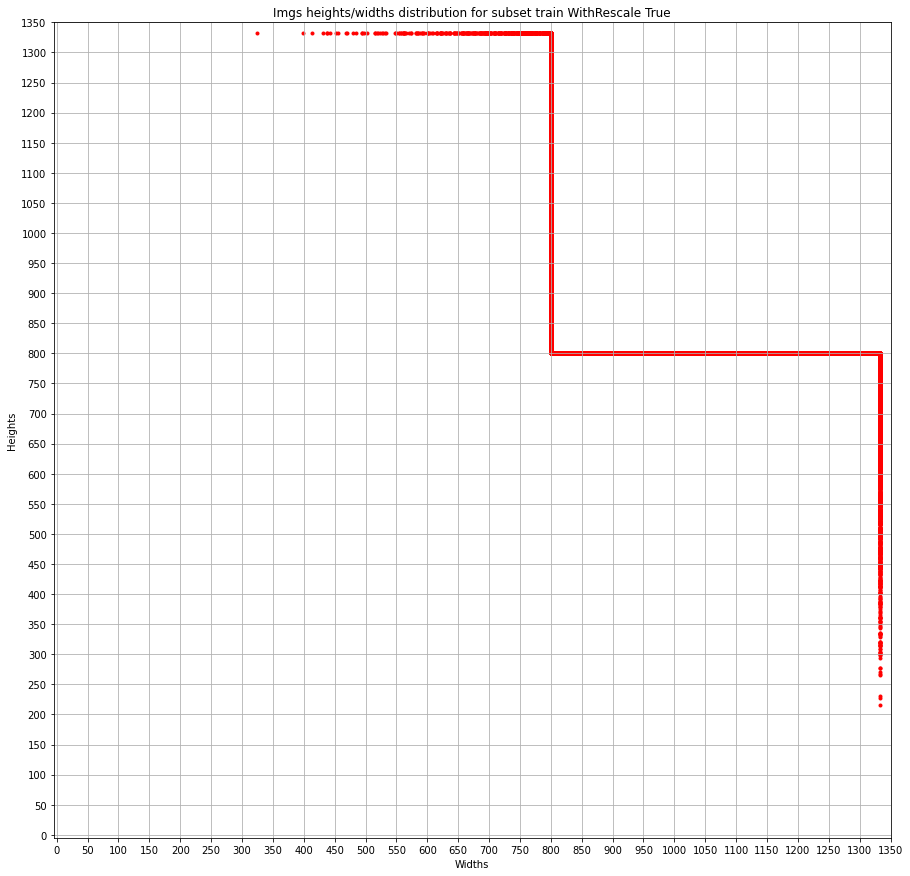

In [19]:
stats(coco, subset, color, mode='Imgs', with_rescale=True, min_size=32)

### Check objects sizes distributions in VOC